# Generative Adversarial Networks (GAN) Learning
This is my implementation of the GAN lecture code from Lazy Programmer's Udemy course 'Deep Learning: Advanced Computer Vision'.

In it we learn how to build a GAN by combining two Tensorflow models built from dense layers, one set up as a generator of images replicating the MNIST dataset, and the other set up as a discriminator which is used to train the generator by detecting rreal vs 'fake' images.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from IPython.utils import io

In [2]:
tf.keras.backend.clear_session()

Start by loading in the mnist data and converting it from 28x28 8-bit grayscale images into 1D arrays of values from -1 to 1.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Update the Y data from 0..255 to -1..1

In [4]:
x_train = x_train / 255.0 * 2 - 1
x_test = x_test / 255.0 * 2 - 1

Flatten the data because we're going to be running it through dense layers, not Conv2D layers.

In [5]:
N, H, W = x_train.shape
print(f'Number of samples (N): {N} Height (H): {H} Width (W): {W}')

Number of samples (N): 60000 Height (H): 28 Width (W): 28


In [6]:
# calculate the size of the flattened dimens (28x28)
D = H * W

# reshape the arrays - specifying -1 as the first dimension tells numpy to use to
# automatically create the first dimension based on dividing the the entire list
# by D.
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

print(f'x_train.shape after: {x_train.shape}')
print(f'x_test.shape after: {x_test.shape}')

x_train.shape after: (60000, 784)
x_test.shape after: (10000, 784)


This is the dimensionality of the latent space and it represents the image the generator will try to create. Once the generator is trained, you can navigate around this latent space and generate see how the various images are related to it. Apparently you can do mathematical operations in latent space and deliberately create output with specific characteristics see [How to Explore the GAN Latent Space When Generating Faces](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/).

In [7]:
# dimensionality of the latent space
# NOTE - this is a hyper parameter, you can play about with this to see the effect it has.
latent_dims = 100

This function builds a generator model which takes input from the latent space and outputs something that we hope will look like one of the images from the MNIST dataset. Note that tanh is used as an activation function because we want output between -1 and 1. Sigmoid would give us output between 0 and 1.

In [8]:
# build the generator
def build_generator(latent_dims):
    i = tf.keras.Input(shape=(latent_dims,))
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(i)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    # end with a tanh activation function because our input values range from -1 to 1
    x = tf.keras.layers.Dense(D, activation='tanh')(x)
    model = tf.keras.Model(i, x, name='generator')
    return model

This is the function that'll build a discriminator. It's quite small with two dense layers using leaky-ReLU activation and a final sigmoid as we have two classifications (fake and real) as outputs.

In [9]:
# build the discriminator
def build_discriminator(img_size):
    i = tf.keras.Input(shape=(img_size,))
    x = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(i)
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(i, x, name='discriminator')
    return model

Create the discriminator and generator models. Notet hat the discriminator is set to untrainable *after* it is compiled. This is important because the trainable attribute is set at compile time so we have a discriminator model we can train, but when we add the discriminator to the combined model, we've got trainable set to false and calling `train_on_batch()` will only train the generator.

In [20]:
# build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# make sure only the generator is trained when this is added to the combined model
discriminator.trainable = False

# build the generator
generator = build_generator(latent_dims)

Create the combined model by adding the generator and discriminator models into a Sequential model. If you look at the summary, you can see that it has effectively embedded the two models into the Sequential and linked them together. We can now call the generator on its own or the combined model which is both the generator and the discriminator.

In [11]:
combined_model = tf.keras.Sequential()
combined_model.add(generator)
combined_model.add(discriminator)

combined_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0002, 0.5)
)

combined_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 784)               1493520   
                                                                 
 discriminator (Functional)  (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


Set up some configuration for batch size, number of epochs etc. The ones and zeros arrays are used for training as Y values we also create lists to hold the losses generated during training so we can plot them later on.

In [12]:
# config
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store losses from discriminator and generator training
d_losses = []
g_losses = []

# create the folder for the images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

Create a function that we can call to create a set of sample images from the latent space after each training epoch. We create a single image that contains 5 x 5 images sampled at random from the latent space. Note this calls `generator.predict(noise)` to do this. The image is then store in a folder so we can have a look later on.

In [13]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dims)
    
    with io.capture_output() as captured:
        imgs = generator.predict(noise)
    
    # rescale the images
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    fig.savefig(f"gan_images/{epoch}.png")
    plt.close()

This is the main training loop. It first trains the discriminator on a random batch of images from the mnist dataset (labelled as genuine) combined with output from the generator which is labelled as fake. Then it trains the generator by passing noise through the combined model into the generator which is then passed through the discriminator as a set of genuine images. The discriminator isn't training at this point so it gives low probability scores for the fake images which are then fed back as the cost to the generator.

In [14]:
# main training loop
for epoch in range(epochs):
    # train the discriminator

    # hide some of the output or it all gets a bit too much for a notebook!
    with io.capture_output() as captured:

        # select a random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]

        # create a batch of fake images
        noise = np.random.randn(batch_size, latent_dims)
        fake_images = generator.predict(noise)

        # train the discriminator
        d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, ones)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_images, zeros)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        # train the generator
        noise = np.random.randn(batch_size, latent_dims)
        g_loss = combined_model.train_on_batch(noise, ones)

    # save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 300 == 0:
        print(f"epoch {epoch + 1}/{epochs}, d_loss: {d_loss:.2f}, \
            d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
        sample_images(epoch)

epoch 1/30000, d_loss: 0.53,             d_acc: 0.80, g_loss: 0.74
epoch 301/30000, d_loss: 0.09,             d_acc: 0.98, g_loss: 3.89
epoch 601/30000, d_loss: 0.66,             d_acc: 0.53, g_loss: 0.74
epoch 901/30000, d_loss: 0.63,             d_acc: 0.61, g_loss: 0.81
epoch 1201/30000, d_loss: 0.60,             d_acc: 0.73, g_loss: 0.83
epoch 1501/30000, d_loss: 0.56,             d_acc: 0.67, g_loss: 0.94
epoch 1801/30000, d_loss: 0.57,             d_acc: 0.69, g_loss: 0.96
epoch 2101/30000, d_loss: 0.50,             d_acc: 0.80, g_loss: 1.05
epoch 2401/30000, d_loss: 0.56,             d_acc: 0.78, g_loss: 0.99
epoch 2701/30000, d_loss: 0.58,             d_acc: 0.69, g_loss: 0.99
epoch 3001/30000, d_loss: 0.54,             d_acc: 0.78, g_loss: 1.05
epoch 3301/30000, d_loss: 0.63,             d_acc: 0.55, g_loss: 0.97
epoch 3601/30000, d_loss: 0.60,             d_acc: 0.69, g_loss: 1.08
epoch 3901/30000, d_loss: 0.61,             d_acc: 0.69, g_loss: 1.05
epoch 4201/30000, d_loss: 

Plot the losses.

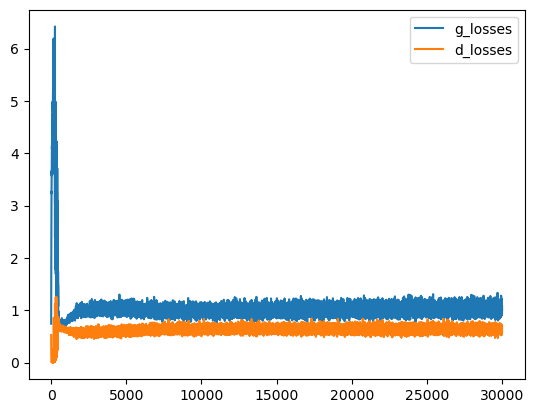

In [15]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

Plot some of the output images.

In [16]:
!ls gan_images

0.png     13200.png 16600.png 2000.png  23400.png 26800.png 3400.png  6800.png
1000.png  13400.png 16800.png 20000.png 23600.png 27000.png 3600.png  7000.png
10000.png 13600.png 17000.png 20200.png 23800.png 27200.png 3800.png  7200.png
10200.png 13800.png 17200.png 20400.png 2400.png  27400.png 400.png   7400.png
10400.png 1400.png  17400.png 20600.png 24000.png 27600.png 4000.png  7600.png
10600.png 14000.png 17600.png 20800.png 24200.png 27800.png 4200.png  7800.png
10800.png 14200.png 17800.png 21000.png 24400.png 2800.png  4400.png  800.png
11000.png 14400.png 1800.png  21200.png 24600.png 28000.png 4600.png  8000.png
11200.png 14600.png 18000.png 21400.png 24800.png 28200.png 4800.png  8200.png
11400.png 14800.png 18200.png 21600.png 25000.png 28400.png 5000.png  8400.png
11600.png 15000.png 18400.png 21800.png 25200.png 28600.png 5200.png  8600.png
11800.png 15200.png 18600.png 2200.png  25400.png 28800.png 5400.png  8800.png
1200.png  15400.png 18800.png 22000.png 25600.png 290

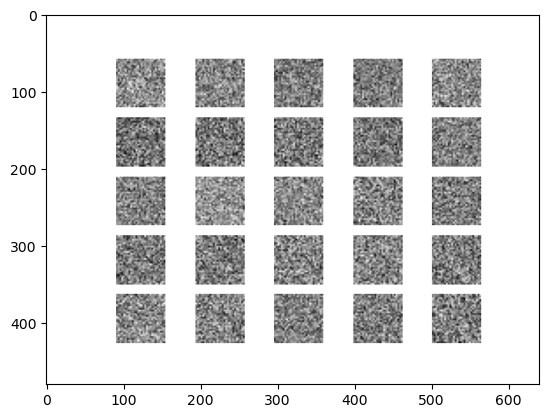

In [17]:
im = plt.imread("gan_images/0.png")
plt.imshow(im)

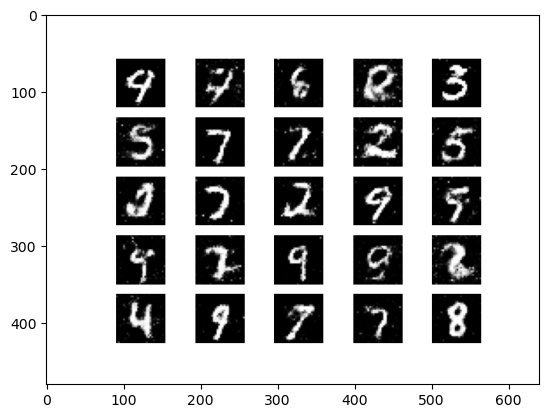

In [18]:
im = plt.imread("gan_images/10000.png")
plt.imshow(im)

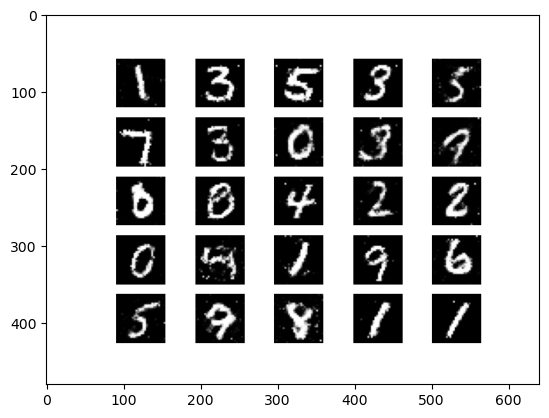

In [19]:
im = plt.imread("gan_images/29800.png")
plt.imshow(im)